In [271]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import random
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [219]:
class Portfolio:
    ## This class is an additional class to support the portfolio trading. Within this class, it would be possible to add portfolio Monitoring
    ## functionalities. Please Note that this class is only for the support of all Trading classes.
    def __init__(self):

        ## get the stock names
        self.s1_name = ''
        self.s2_name = ''

        self.s1_amount = 0
        self.s2_amount = 0
        self.money = 0
        self.pf_value =  ''
        self.sharpe = ''
        self.open_days = []
        self.avg_open_days = ''

    def sharpe_ratio(self):
        #self.pf_value.astype('float32')
        returns = self.pf_value.pct_change()
        returns = returns[1:]
        self.sharpe = returns.mean()/returns.std()

    def average_open_days(self):
        if len(self.open_days) == 0:
            self.avg_open_days = 0
        else:
            self.avg_open_days = sum(self.open_days)/len(self.open_days)


In [220]:
class RegularTrading:
    ## This is the first trading class for the thesis. It only supports Regular trading without the addition of a Stoploss or potential last day trading.
    ## Usecase of this class is the initial Start of the analysis for the individual timeframes. The functions within the class
    ## are explained where necessary.

    def __init__(self, start_date, end_date):
        ## setting start and end date of the crisis
        self.start_date = start_date
        self.end_date = end_date

        ## setting datapoints of the trading
        self.tickers = ''
        self.data = ''
        self.normed_data = ''

        self.trading_data = {}

        self.distance_data = ''
        self.run()


    def run(self):
        ## This method is used to auto-initialize the RegularTrading Class. With its help, we can focus on the important stuff - the analysis.

        self.tickers = self.get_ticker()
        self.data = self.get_ticker_data()
        self.normed_data = self.normer(self.data)
        self.distance_data = self.calc_distance(self.normed_data)
        self.perform_distance_trading()

    def get_ticker(self):

        ##This method is a function to return all stock picks. With its return of the Stock picks, we can easliy track
        ## which tickers have been traded.

        companies = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
        tickers = companies[0].Symbol.to_list()
        random.seed(42)
        stock_picks = random.sample(tickers, k = 25)
        return stock_picks

    def get_ticker_data(self):

        ## This is the download function to get all the ticker data from yfinance. For this usage, only the
        ## Adjusted Close will be downloaded.

        df = yf.download(self.tickers, self.start_date, self.end_date)['Adj Close']
        return df


    def train_split(self, data, length):

        ## This method is seperating the dataframe into the train period.

        train_period = pd.Series(dtype= 'float64')
        train_period = data.iloc[:int(len(data)*length)]
        return train_period

    def test_split(self, data, length):

        ## This method is seperating the dataframe into the test period.

        test_period = pd.Series(dtype= 'float64')
        test_period = data.iloc[int(len(data)*length):]
        return test_period

    def data_split(self, data, thres):
        ## This method takes the input data and splits it to two dataframes: train and test.
        train = self.train_split(data, thres)
        test = self.test_split(data, thres)
        return train, test

    def normer(self, data):

        ##The normer method (as the name suggests) divides the input data with the first price from the input timeseries and returns the normalized data"""
        normed_data = data/data.iloc[0]
        return normed_data

    def calc_distance(self, data):

        ## The calc_distance method calculates the euclidean distance from all timeseries of the normed data. It lists them in an ascending order
        ## in the dataframe - this is a crucial step in the processing of the output."""
        df = pd.DataFrame()
        for a1 in data.columns:
            for a2 in data.columns:

                if a1 != a2:

                    ## using the euclidean distance
                    diff = sum((data[a1] - data[a2])**2)

                    ## the calculated data will be appended to the dataframe with the series s below:

                    s = pd.Series({
                        'stock1': a1,
                        'stock2': a2,
                        'diff': diff
                    })

                    df = pd.concat([df, s.to_frame().T], ignore_index = True)

        df = df.drop_duplicates(subset = 'diff')
        df = df.sort_values(by = 'diff', ascending = True)
        df = df.reset_index()
        df.drop('index', axis = 1, inplace = True)

        return df

    def distance_trade_prep(self, stock1, stock2):

        ## This method prepares the input of the stocks (stock1 and stock2) for the further trading in the process. It will be used for the formation period
        ## of the trading. Therefore, the return of the method are the normed train data as well as the mean and the standard deviation.

        s = pd.Series(dtype= 'float64')


        train_s1, _ = self.data_split(stock1, 0.75)
        train_s2, _ = self.data_split(stock2, 0.75)

        normed_s1 = self.normer(train_s1)
        normed_s2 = self.normer(train_s2)

        s = normed_s1 - normed_s2

        mean = s.mean()
        std = s.std()

        return mean, std

    def pre_trade(self, stock1, stock2, mean, std, p: Portfolio()):

        ## This method will prepare everything for the trading itself. The returns are the difference of the trading data, the price
        ## data for the two stocks, the mean, std-deviation and the start portfolio which contains an
        ## stock1 amount of 0, stock2 amount of 0 and 0 money. This all is achived by combining the previous methods into the function.

        normed_s1 = self.normer(stock1)
        normed_s2 = self.normer(stock2)

        _, trade_normed1 = self.data_split(data = normed_s1,thres= 0.75)
        _, trade_normed2 = self.data_split(data = normed_s2, thres= 0.75)

        _, trade1 = self.data_split(data = stock1, thres = 0.75)
        _, trade2 = self.data_split(data = stock2, thres = 0.75)

        diff_trade = trade_normed1 - trade_normed2

        p.s1_name = stock1.name
        p.s2_name = stock2.name

        p.s1_amount = 0
        p.s2_amount = 0
        p.money = 0.01

        mean = mean
        std = std

        return diff_trade, trade1, trade2, mean, std, p



    def trading(self, diff_trade, trade1, trade2, mean, std, thres, p: Portfolio()):

        ## The Trading Function is spectacular unspectacular - it uses the provided inputs (stock1, stock2, pre-calculated mean, pre-calculated std,
        ## the threshold for the trading signals and the portfolio itself. Within the RegularTrading Class,
        ## the inclusion of the portfolio doesn't have o much impact, but in the later stages (and Classes) it will show its benefits.

        df = pd.DataFrame()

        thres = thres


        diff_trade = diff_trade

        mean = mean
        std = std
        thres = thres

        y = 0

        for i in range(len(diff_trade)):

            portfolio_val = float(-(p.s1_amount * trade1[y] - p.s1_amount * trade1[i] + p.s2_amount * trade2[y] - p.s2_amount * trade2[i]) + p.money)

            if (diff_trade[i] > (mean + std * thres)):

                if (p.s1_amount != 0):
                    pass

                else:
                    p.s1_amount -= trade1[i]/trade1[i]
                    p.s2_amount += trade1[i]/trade2[i]
                    y = i


            elif (diff_trade[i] < (mean - std*thres)):

                if (p.s1_amount != 0):
                    pass

                else:
                    p.s1_amount += trade2[i]/trade1[i]
                    p.s2_amount -= trade2[i]/trade2[i]
                    #money += trade2[i] - trade1[i]
                    y = i

            elif ((p.s1_amount < 0) and ((diff_trade[i]) <= mean)):


                print(y)
                print(i)
                print(trade1[y], trade1[i])
                print(trade2[y], trade2[i])

                print('s1y ' + str(-p.s1_amount * trade1[y]))
                print('s1i ' + str(p.s1_amount * trade1[i]))

                print('s2y ' + str(-p.s2_amount * trade2[y]))
                print('s2i ' + str(p.s2_amount * trade2[i]))

                p.open_days.append(i-y)

                p.money -= p.s1_amount * trade1[y] - p.s1_amount * trade1[i] + p.s2_amount * trade2[y] - p.s2_amount * trade2[i]
                p.s1_amount = 0
                p.s2_amount = 0
                y = 0
                print('position closed')

            elif ((p.s1_amount > 0) and ((diff_trade[i]) >= mean)):

                print(y)
                print(i)

                print('s1y ' + str(-p.s1_amount * trade1[y]))
                print('s1i ' + str(p.s1_amount * trade1[i]))

                print('s2y ' + str(-p.s2_amount * trade2[y]))
                print('s2i ' + str(p.s2_amount * trade2[i]))


                print(trade1[y], trade1[i])
                print(trade2[y], trade2[i])

                p.open_days.append(i-y)

                p.money -= p.s1_amount * trade1[y] - p.s1_amount * trade1[i] - p.s2_amount * trade2[i] + p.s2_amount * trade2[y]
                p.s1_amount = 0
                p.s2_amount = 0
                y = 0
                print('position closed')



            print(i, p.money, p.s1_amount, p.s2_amount)

            s = pd.Series({
                'Date': diff_trade.index[i],
                'money': p.money,
                'stock1': p.s1_amount,
                'stock2': p.s2_amount,
                'diff': diff_trade[i],
                'mean': mean,
                'portfolio_val': portfolio_val

            })



            df = pd.concat([df, s.to_frame().T], ignore_index = True)

        df = df.set_index(df['Date'])
        df = df.drop('Date', axis = 1)
        if p.s1_amount != 0:
            df['portfolio_val'] = 0.01

        p.pf_value = df['portfolio_val']



        return p, df

    def distance_trading(self, stock1, stock2, thres):

        ## The distance_trading function takes ALL of the previous methods and combines them into one. Its returns are the portfolio
        ## and the the trade df which contains additional information regarding the trade distance, stock holdings and money evolution.

        thres = thres
        portfolio = Portfolio()

        mean, std = self.distance_trade_prep(stock1 = stock1, stock2 = stock2)

        diff_trade, trade1, trade2, mean, std, portfolio = self.pre_trade(stock1, stock2, mean, std, portfolio)

        portfolio, df = self.trading(diff_trade, trade1, trade2, mean, std, thres, portfolio)

        portfolio.sharpe_ratio()
        portfolio.average_open_days()

        return portfolio, df


    def perform_distance_trading(self):

        ## The final form of Trading: this method just uses the top 15% pairs with the least euclidean distance and
        ## returns it to the trading data dict.
        for i in range(int(len(self.distance_data)*0.15)):
            self.trading_data[i] = self.distance_trading(self.data[self.distance_data['stock1'][i]], self.data[self.distance_data['stock2'][i]], 1.5)


In [221]:
class LDS_Trading:
    ## This is the first trading class for the thesis. It only supports Regular trading without the addition of a Stoploss or potential last day trading.
    ## Usecase of this class is the initial Start of the analysis for the individual timeframes. The functions within the class
    ## are explained where necessary.

    def __init__(self, start_date, end_date):
        ## setting start and end date of the crisis
        self.start_date = start_date
        self.end_date = end_date

        ## setting datapoints of the trading
        self.tickers = ''
        self.data = ''
        self.normed_data = ''

        self.trading_data = {}

        self.distance_data = ''
        self.run()


    def run(self):
        ## This method is used to auto-initialize the RegularTrading Class. With its help, we can focus on the important stuff - the analysis.

        self.tickers = self.get_ticker()
        self.data = self.get_ticker_data()
        self.normed_data = self.normer(self.data)
        self.distance_data = self.calc_distance(self.normed_data)
        self.perform_distance_trading()

    def get_ticker(self):

        ##This method is a function to return all stock picks. With its return of the Stock picks, we can easliy track
        ## which tickers have been traded.

        companies = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
        tickers = companies[0].Symbol.to_list()
        random.seed(42)
        stock_picks = random.sample(tickers, k = 25)
        return stock_picks

    def get_ticker_data(self):

        ## This is the download function to get all the ticker data from yfinance. For this usage, only the
        ## Adjusted Close will be downloaded.

        df = yf.download(self.tickers, self.start_date, self.end_date)['Adj Close']
        return df


    def train_split(self, data, length):

        ## This method is seperating the dataframe into the train period.

        train_period = pd.Series(dtype= 'float64')
        train_period = data.iloc[:int(len(data)*length)]
        return train_period

    def test_split(self, data, length):

        ## This method is seperating the dataframe into the test period.

        test_period = pd.Series(dtype= 'float64')
        test_period = data.iloc[int(len(data)*length):]
        return test_period

    def data_split(self, data, thres):
        ## This method takes the input data and splits it to two dataframes: train and test.
        train = self.train_split(data, thres)
        test = self.test_split(data, thres)
        return train, test

    def normer(self, data):

        ##The normer method (as the name suggests) divides the input data with the first price from the input timeseries and returns the normalized data"""
        normed_data = data/data.iloc[0]
        return normed_data

    def calc_distance(self, data):

        ## The calc_distance method calculates the euclidean distance from all timeseries of the normed data. It lists them in an ascending order
        ## in the dataframe - this is a crucial step in the processing of the output."""
        df = pd.DataFrame()
        for a1 in data.columns:
            for a2 in data.columns:

                if a1 != a2:

                    ## using the euclidean distance
                    diff = sum((data[a1] - data[a2])**2)

                    ## the calculated data will be appended to the dataframe with the series s below:

                    s = pd.Series({
                        'stock1': a1,
                        'stock2': a2,
                        'diff': diff
                    })

                    df = pd.concat([df, s.to_frame().T], ignore_index = True)

        df = df.drop_duplicates(subset = 'diff')
        df = df.sort_values(by = 'diff', ascending = True)
        df = df.reset_index()
        df.drop('index', axis = 1, inplace = True)

        return df

    def distance_trade_prep(self, stock1, stock2):

        ## This method prepares the input of the stocks (stock1 and stock2) for the further trading in the process. It will be used for the formation period
        ## of the trading. Therefore, the return of the method are the normed train data as well as the mean and the standard deviation.

        s = pd.Series(dtype= 'float64')


        train_s1, _ = self.data_split(stock1, 0.75)
        train_s2, _ = self.data_split(stock2, 0.75)

        normed_s1 = self.normer(train_s1)
        normed_s2 = self.normer(train_s2)

        s = normed_s1 - normed_s2

        mean = s.mean()
        std = s.std()

        return mean, std

    def pre_trade(self, stock1, stock2, mean, std, p: Portfolio()):

        ## This method will prepare everything for the trading itself. The returns are the difference of the trading data, the price
        ## data for the two stocks, the mean, std-deviation and the start portfolio which contains an
        ## stock1 amount of 0, stock2 amount of 0 and 0 money. This all is achived by combining the previous methods into the function.

        normed_s1 = self.normer(stock1)
        normed_s2 = self.normer(stock2)

        _, trade_normed1 = self.data_split(data = normed_s1,thres= 0.75)
        _, trade_normed2 = self.data_split(data = normed_s2, thres= 0.75)

        _, trade1 = self.data_split(data = stock1, thres = 0.75)
        _, trade2 = self.data_split(data = stock2, thres = 0.75)

        diff_trade = trade_normed1 - trade_normed2

        p.s1_name = stock1.name
        p.s2_name = stock2.name

        p.s1_amount = 0
        p.s2_amount = 0
        p.money = 0.01

        mean = mean
        std = std

        return diff_trade, trade1, trade2, mean, std, p



    def trading(self, diff_trade, trade1, trade2, mean, std, thres, p: Portfolio()):

        ## The Trading Function is spectacular unspectacular - it uses the provided inputs (stock1, stock2, pre-calculated mean, pre-calculated std,
        ## the threshold for the trading signals and the portfolio itself. Within the RegularTrading Class,
        ## the inclusion of the portfolio doesn't have o much impact, but in the later stages (and Classes) it will show its benefits.

        df = pd.DataFrame()

        thres = thres


        diff_trade = diff_trade

        mean = mean
        std = std
        thres = thres

        y = 0

        for i in range(len(diff_trade)):

            portfolio_val = -(p.s1_amount * trade1[y] - p.s1_amount * trade1[i] + p.s2_amount * trade2[y] - p.s2_amount * trade2[i]) + p.money

            if (diff_trade[i] > (mean + std * thres)):

                if (p.s1_amount != 0) and (i != len(diff_trade)-1):
                    pass

                elif ((i == len(diff_trade)-1) and (p.s1_amount != 0)):

                    p.open_days.append(i-y)

                    p.money -= p.s1_amount * trade1[y] - p.s1_amount * trade1[i] - p.s2_amount * trade2[i] + p.s2_amount * trade2[y]
                    p.s1_amount = 0
                    p.s2_amount = 0
                    y = 0

                    print('last position closed '+ str(i))

                else:
                    p.s1_amount -= trade1[i]/trade1[i]
                    p.s2_amount += trade1[i]/trade2[i]
                    y = i


            elif (diff_trade[i] < (mean - std*thres)):

                if (p.s1_amount != 0) and (i != len(diff_trade)-1):
                    pass

                elif ((i == len(diff_trade)-1) and (p.s1_amount != 0)):

                    p.open_days.append(i-y)

                    p.money -= p.s1_amount * trade1[y] - p.s1_amount * trade1[i] - p.s2_amount * trade2[i] + p.s2_amount * trade2[y]
                    p.s1_amount = 0
                    p.s2_amount = 0
                    y = 0
                    print('last position closed '+ str(i))

                else:
                    p.s1_amount += trade2[i]/trade1[i]
                    p.s2_amount -= trade2[i]/trade2[i]
                    #money += trade2[i] - trade1[i]
                    y = i

            elif ((p.s1_amount < 0) and ((diff_trade[i]) <= mean)):



                p.open_days.append(i-y)

                p.money -= p.s1_amount * trade1[y] - p.s1_amount * trade1[i] + p.s2_amount * trade2[y] - p.s2_amount * trade2[i]
                p.s1_amount = 0
                p.s2_amount = 0
                y = 0
                print('position closed')

            elif ((p.s1_amount > 0) and ((diff_trade[i]) >= mean)):


                p.open_days.append(i-y)

                p.money -= p.s1_amount * trade1[y] - p.s1_amount * trade1[i] - p.s2_amount * trade2[i] + p.s2_amount * trade2[y]
                p.s1_amount = 0
                p.s2_amount = 0
                y = 0
                print('position closed')

            elif (p.s1_amount != 0) and (i == len(diff_trade)-1):
                p.open_days.append(i-y)

                p.money -= p.s1_amount * trade1[y] - p.s1_amount * trade1[i] - p.s2_amount * trade2[i] + p.s2_amount * trade2[y]
                p.s1_amount = 0
                p.s2_amount = 0
                y = 0
                print('position closed')



            print(i, p.money, p.s1_amount, p.s2_amount)

            s = pd.Series({
                'Date': diff_trade.index[i],
                'money': p.money,
                'stock1': p.s1_amount,
                'stock2': p.s2_amount,
                'diff': diff_trade[i],
                'mean': mean,
                'portfolio_val': portfolio_val

            })



            df = pd.concat([df, s.to_frame().T], ignore_index = True)

        df = df.set_index(df['Date'])
        df = df.drop('Date', axis = 1)

        p.pf_value = df['portfolio_val']

        return p, df

    def distance_trading(self, stock1, stock2, thres):

        ## The distance_trading function takes ALL of the previous methods and combines them into one. Its returns are the portfolio
        ## and the the trade df which contains additional information regarding the trade distance, stock holdings and money evolution.

        thres = thres
        portfolio = Portfolio()

        mean, std = self.distance_trade_prep(stock1 = stock1, stock2 = stock2)

        diff_trade, trade1, trade2, mean, std, portfolio = self.pre_trade(stock1, stock2, mean, std, portfolio)

        portfolio, df = self.trading(diff_trade, trade1, trade2, mean, std, thres, portfolio)

        portfolio.sharpe_ratio()
        portfolio.average_open_days()

        return portfolio, df


    def perform_distance_trading(self):

        ## The final form of Trading: this method just uses the top 15% pairs with the least euclidean distance and
        ## returns it to the trading data dict.
        for i in range(int(len(self.distance_data)*0.15)):
            self.trading_data[i] = self.distance_trading(self.data[self.distance_data['stock1'][i]], self.data[self.distance_data['stock2'][i]], 1.5)


In [222]:
class EnhancedTrading:

    ## This is the last trading class for the thesis. It supports the enhanced Trading with the addition of a Stoploss or potential last day
    ## trading.
    ## Usecase of this class is the is the most advanced strat for the thesis. The functions within the class
    ## are explained where necessary.

    def __init__(self, start_date, end_date):
        ## setting start and end date of the crisis
        self.start_date = start_date
        self.end_date = end_date

        ## setting datapoints of the trading
        self.tickers = ''
        self.data = ''
        self.normed_data = ''

        self.trading_data = {}

        self.distance_data = ''


        self.run()


    def run(self):
        ## This method is used to auto-initialize the RegularTrading Class. With its help, we can focus on the important stuff - the analysis.

        self.tickers = self.get_ticker()
        self.data = self.get_ticker_data()
        self.normed_data = self.normer(self.data)
        self.distance_data = self.calc_distance(self.normed_data)
        self.perform_distance_trading()

    def get_ticker(self):

        ##This method is a function to return all stock picks. With its return of the Stock picks, we can easliy track
        ## which tickers have been traded.

        companies = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
        tickers = companies[0].Symbol.to_list()
        random.seed(42)
        stock_picks = random.sample(tickers, k = 25)
        return stock_picks

    def get_ticker_data(self):

        ## This is the download function to get all the ticker data from yfinance. For this usage, only the
        ## Adjusted Close will be downloaded.

        df = yf.download(self.tickers, self.start_date, self.end_date)['Adj Close']
        return df


    def train_split(self, data, length):

        ## This method is seperating the dataframe into the train period.

        train_period = pd.Series(dtype= 'float64')
        train_period = data.iloc[:int(len(data)*length)]
        return train_period

    def test_split(self, data, length):

        ## This method is seperating the dataframe into the test period.

        test_period = pd.Series(dtype= 'float64')
        test_period = data.iloc[int(len(data)*length):]
        return test_period

    def data_split(self, data, thres):
        ## This method takes the input data and splits it to two dataframes: train and test.
        train = self.train_split(data, thres)
        test = self.test_split(data, thres)
        return train, test

    def normer(self, data):

        ##The normer method (as the name suggests) divides the input data with the first price from the input timeseries and returns the normalized data"""
        normed_data = data/data.iloc[0]
        return normed_data

    def calc_distance(self, data):

        ## The calc_distance method calculates the euclidean distance from all timeseries of the normed data. It lists them in an ascending order
        ## in the dataframe - this is a crucial step in the processing of the output."""
        df = pd.DataFrame()
        for a1 in data.columns:
            for a2 in data.columns:

                if a1 != a2:

                    ## using the euclidean distance
                    diff = sum((data[a1] - data[a2])**2)

                    ## the calculated data will be appended to the dataframe with the series s below:

                    s = pd.Series({
                        'stock1': a1,
                        'stock2': a2,
                        'diff': diff
                    })

                    df = pd.concat([df, s.to_frame().T], ignore_index = True)

        df = df.drop_duplicates(subset = 'diff')
        df = df.sort_values(by = 'diff', ascending = True)
        df = df.reset_index()
        df.drop('index', axis = 1, inplace = True)

        return df

    def distance_trade_prep(self, stock1, stock2):

        ## This method prepares the input of the stocks (stock1 and stock2) for the further trading in the process. It will be used for the formation period
        ## of the trading. Therefore, the return of the method are the normed train data as well as the mean and the standard deviation.

        s = pd.Series(dtype= 'float64')

        normed_s1 = self.normer(stock1)
        normed_s2 = self.normer(stock2)

        train_s1, _ = self.data_split(normed_s1, 0.75)
        train_s2, _ = self.data_split(normed_s2, 0.75)



        s = train_s1 - train_s2

        mean = s.mean()
        std = s.std()

        return mean, std

    def pre_trade(self, stock1, stock2, mean, std, p: Portfolio()):

        ## This method will prepare everything for the trading itself. The returns are the difference of the trading data, the price
        ## data for the two stocks, the mean, std-deviation and the start portfolio which contains an
        ## stock1 amount of 0, stock2 amount of 0 and 0 money. This all is achived by combining the previous methods into the function.

        normed_s1 = self.normer(stock1)
        normed_s2 = self.normer(stock2)

        _, trade_normed1 = self.data_split(data = normed_s1,thres= 0.75)
        _, trade_normed2 = self.data_split(data = normed_s2, thres= 0.75)

        _, trade1 = self.data_split(data = stock1, thres = 0.75)
        _, trade2 = self.data_split(data = stock2, thres = 0.75)

        diff_trade = trade_normed1 - trade_normed2

        p.s1_name = stock1.name
        p.s2_name = stock2.name

        p.s1_amount = 0
        p.s2_amount = 0
        p.money = 0.01

        mean = mean
        std = std

        return diff_trade, trade1, trade2, mean, std, p


    def stop_loss_trading(self, diff_trade, trade1, trade2, mean, std, thres, p: Portfolio, last_day_sell = None):

        """
        The Trading Function is spectacular unspectacular - it uses the provided inputs (stock1, stock2, pre-calculated mean, pre-calculate
        std, the threshold for the trading signals and the portfolio itself. The added portfolio from the classes before
        are really beneficial for the execution of the enhanced trading - the position sizes and money account are
        directly transferred to the new trading algorhithm.

        -------------
        Inputs:
        diff_trade: preprocessed trading difference between two stocks
        trade1: trading prices of stock1
        trade2: trading prices of stock2
        mean: precalculated mean of the training difference between the two prices
        std: precalculated std of the training difference between the two prices
        p: Portfolio, which contains all the current holdings
        last_day_sell: specifies whether all positions should be sold on the last trading day.

        -------------
        Returns:
        p: Portfolio with all current stock and money holdings
        df: Trading dataframe with (most) trading information

        """


        df = pd.DataFrame()

        thres = thres


        diff_trade = diff_trade
        trade1 = trade1
        trade2 = trade2


        mean = mean
        std = std
        thres = thres
        y = 0


        for i in range(len(diff_trade)):

            if (diff_trade[i] > (mean + std * thres)) and (diff_trade[i] < (mean + std * (thres * 2))):

                if (p.s1_amount != 0) and (i != len(diff_trade)):
                    pass

                else:
                    p.s1_amount -= trade1[i]/trade1[i]
                    p.s2_amount += trade1[i]/trade2[i]

                    y = i

            elif ((p.s1_amount == 0) and (diff_trade[i] < (mean - std * (thres * 2))) or (diff_trade[i] > (mean + std * (thres * 2)))):
                pass

            elif (diff_trade[i] < (mean - std * thres)) and (diff_trade[i] > (mean - std * (thres * 2))):

                if (p.s1_amount != 0) and (i != len(diff_trade)):
                    pass

                else:
                    p.s1_amount += trade2[i]/trade1[i]
                    p.s2_amount -= trade2[i]/trade2[i]
                    y = i

            elif ((p.s1_amount < 0) and ((diff_trade[i]) <= mean)):

                p.open_days.append(i-y)

                p.money -= p.s1_amount * trade1[y] - p.s1_amount * trade1[i] + p.s2_amount * trade2[y] - p.s2_amount * trade2[i]
                p.s1_amount = 0
                p.s2_amount = 0
                y = 0
                print('position closed')

            elif ((p.s1_amount > 0) and ((diff_trade[i]) >= mean)):

                p.open_days.append(i-y)

                p.money -= p.s1_amount * trade1[y] - p.s1_amount * trade1[i] - p.s2_amount * trade2[i] + p.s2_amount * trade2[y]
                p.s1_amount = 0
                p.s2_amount = 0
                y = 0
                print('position closed')


            elif (diff_trade[i] < (mean - std * (thres * 2))) or (diff_trade[i] > (mean + std * (thres * 2))):

                p.open_days.append(i-y)

                p.money -= p.s1_amount * trade1[y] - p.s1_amount * trade1[i] - p.s2_amount * trade2[i] + p.s2_amount * trade2[y]
                p.s1_amount = 0
                p.s2_amount = 0
                y = 0
                print('Position closed because of stop loss')



            elif last_day_sell == True:
                if ((i == len(diff_trade)-1) and (p.s1_amount != 0)):

                    p.open_days.append(i-y)

                    p.money -= p.s1_amount * trade1[y] - p.s1_amount * trade1[i] - p.s2_amount * trade2[i] + p.s2_amount * trade2[y]
                    p.s1_amount = 0
                    p.s2_amount = 0
                    y = 0

                    print('last position closed '+ str(i))

                else:
                    pass

            print(p.s1_amount, p.s2_amount, p.money)

            portfolio_val = -(p.s1_amount * trade1[y] - p.s1_amount * trade1[i] + p.s2_amount * trade2[y] - p.s2_amount * trade2[i]) + p.money

            s = pd.Series({
                'Date': diff_trade.index[i],
                'money': p.money,
                'stock1': p.s1_amount,
                'stock2': p.s2_amount,
                'diff': diff_trade[i],
                'mean': mean,
                'portfolio_val': portfolio_val

            })


            df = pd.concat([df, s.to_frame().T], ignore_index = True)
        df = df.set_index(df['Date'])
        df = df.drop('Date', axis = 1)

        p.pf_value = df['portfolio_val']

        return p, df


    def enhanced_trading(self, diff_trade, trade1, trade2, mean, std, thres, p: Portfolio()):

        df1 = pd.DataFrame()

        p, df = self.stop_loss_trading(diff_trade, trade1, trade2, mean, std, thres, p)

        if (abs(df['diff'][-2]) > abs(df['diff'][-1])) and (p.s1_amount != 0):

            print('verlängerung hier hin')
            start1 = df.index[0]
            end1 = df.index[-1] + datetime.timedelta(30)

            additional_1 = yf.download(p.s1_name, start = start1, end = end1)['Adj Close']
            additional_2 = yf.download(p.s2_name, start = start1, end = end1)['Adj Close']

            diff_trade_new = additional_1/self.data[p.s1_name][0] - additional_2/self.data[p.s2_name][0]

            p.s1_amount = 0
            p.s2_amount = 0
            p.money = 0.01

            p, df1 = self.stop_loss_trading(diff_trade_new, additional_1, additional_2, mean, std, thres, p, last_day_sell = True)

            plt.plot(p.pf_value)

        else:
            p.money = df['portfolio_val'][-1]
            p.s1_amount = 0
            p.s2_amount = 0


        #plt.plot(diff_trade, label = str(p.s1_name + '_' + p.s2_name))
        #plt.axhline(mean)
        #plt.axhline(mean + std * thres)
        #plt.axhline(mean + std*thres*2)
        #plt.axhline(mean - std*thres)
        #plt.axhline(mean - std*thres*2)
        #plt.plot(p.pf_value)
        #plt.legend()



        df = df1

        return p, df

    def distance_trading(self, stock1, stock2, thres):

        ## The distance_trading function takes ALL of the previous methods and combines them into one. Its returns are the portfolio
        ## and the the trade df which contains additional information regarding the trade distance, stock holdings and money evolution.

        thres = thres
        portfolio = Portfolio()


        mean, std = self.distance_trade_prep(stock1 = stock1, stock2 = stock2)

        diff_trade, trade1, trade2, mean, std, portfolio = self.pre_trade(stock1, stock2, mean, std, portfolio)

        portfolio, df = self.enhanced_trading(diff_trade, trade1, trade2, mean, std, thres, portfolio)

        portfolio.sharpe_ratio()
        portfolio.average_open_days()
        return portfolio, df


    def perform_distance_trading(self):

        ## The final form of Trading: this method just uses the top 15% pairs with the least euclidean distance and
        ## returns it to the trading data dict.
        for i in range(int(len(self.distance_data)*0.15)):
            self.trading_data[i] = self.distance_trading(self.data[self.distance_data['stock1'][i]], self.data[self.distance_data['stock2'][i]], 1.5)


In [223]:
class Analytics:
    def __init__(self, Trading_Object):
        self.Trading_Object = Trading_Object
        self.money_data = []
        self.trading_days_data = []
        self.sharpe_ratio_data = []

        self.money_quantiles = {}
        self.trading_days_quantiles = {}
        self.sharpe_quantiles = {}

        self.analytics_df = pd.DataFrame()

        self.run()

    def run(self):
        self.get_data()
        self.calculate_data()
        self.convert_to_df()
        print(self.analytics_df)

    def get_data(self):
        money = []
        sharpe = []
        open_days = []
        for i in self.Trading_Object.trading_data:
            self.money_data.append(self.Trading_Object.trading_data[i][0].money)
            self.sharpe_ratio_data.append(self.Trading_Object.trading_data[i][0].sharpe)
            self.trading_days_data.append(self.Trading_Object.trading_data[i][0].avg_open_days)


    def calculate_data(self):
        quantiles = [0, 0.25, 0.5, 0.75, 1]

        for q in quantiles:
            self.money_quantiles[q] = np.nanquantile(a = self.money_data, q = q)
            self.trading_days_quantiles[q] = np.nanquantile(a = self.trading_days_data, q = q)
            self.sharpe_quantiles[q] = np.nanquantile(a = self.sharpe_ratio_data, q = q)

        self.money_quantiles['mean'] = np.nanmean(self.money_data)
        self.trading_days_quantiles['mean'] = np.nanmean(self.trading_days_data)
        self.sharpe_quantiles['mean'] = np.nanmean(self.sharpe_ratio_data)

    def convert_to_df(self):
        self.analytics_df = pd.DataFrame.from_dict([self.money_quantiles, self.sharpe_quantiles, self.trading_days_quantiles])
        self.analytics_df.index = ['Monetary Return', 'Sharpe Ratio', 'Trading Days']
        self.analytics_df.columns = ['Minimum', '25% Quantile', '50% Quantile', '75% Quantile', 'Maximum', 'Mean']


# Referenzzeitraum 2006

[*********************100%***********************]  25 of 25 completed

3 Failed downloads:
- NCLH: Data doesn't exist for startDate = 1136091600, endDate = 1167627600
- GNRC: Data doesn't exist for startDate = 1136091600, endDate = 1167627600
- CFG: Data doesn't exist for startDate = 1136091600, endDate = 1167627600
0 0.01 0 0
1 0.01 0 0
2 0.01 0 0
3 0.01 0 0
4 0.01 0 0
5 0.01 0 0
6 0.01 0 0
7 0.01 0 0
8 0.01 0 0
9 0.01 0 0
10 0.01 0 0
11 0.01 0 0
12 0.01 0 0
13 0.01 0 0
14 0.01 0 0
15 0.01 0 0
16 0.01 0 0
17 0.01 0 0
18 0.01 0 0
19 0.01 0 0
20 0.01 0 0
21 0.01 0 0
22 0.01 2.5247040349492673 -1.0
23 0.01 2.5247040349492673 -1.0
24 0.01 2.5247040349492673 -1.0
25 0.01 2.5247040349492673 -1.0
26 0.01 2.5247040349492673 -1.0
27 0.01 2.5247040349492673 -1.0
28 0.01 2.5247040349492673 -1.0
29 0.01 2.5247040349492673 -1.0
30 0.01 2.5247040349492673 -1.0
31 0.01 2.5247040349492673 -1.0
32 0.01 2.5247040349492673 -1.0
33 0.01 2.5247040349492673 -1.0
34 0.01 2.5247040349492673 -1.0
35 0.01 2.5

/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/

30 1.9392989998278074 0 0
31 1.9392989998278074 0 0
32 1.9392989998278074 0 0
33 1.9392989998278074 0 0
34 1.9392989998278074 -1.0 2.802709542960569
35 1.9392989998278074 -1.0 2.802709542960569
36 1.9392989998278074 -1.0 2.802709542960569
37 1.9392989998278074 -1.0 2.802709542960569
38 1.9392989998278074 -1.0 2.802709542960569
39 1.9392989998278074 -1.0 2.802709542960569
40 1.9392989998278074 -1.0 2.802709542960569
41 1.9392989998278074 -1.0 2.802709542960569
42 1.9392989998278074 -1.0 2.802709542960569
43 1.9392989998278074 -1.0 2.802709542960569
44 1.9392989998278074 -1.0 2.802709542960569
45 1.9392989998278074 -1.0 2.802709542960569
46 1.9392989998278074 -1.0 2.802709542960569
47 1.9392989998278074 -1.0 2.802709542960569
48 1.9392989998278074 -1.0 2.802709542960569
49 1.9392989998278074 -1.0 2.802709542960569
50 1.9392989998278074 -1.0 2.802709542960569
51 1.9392989998278074 -1.0 2.802709542960569
52 1.9392989998278074 -1.0 2.802709542960569
53 1.9392989998278074 -1.0 2.802709542960

/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()


[*********************100%***********************]  25 of 25 completed

3 Failed downloads:
- NCLH: Data doesn't exist for startDate = 1136091600, endDate = 1167627600
- GNRC: Data doesn't exist for startDate = 1136091600, endDate = 1167627600
- CFG: Data doesn't exist for startDate = 1136091600, endDate = 1167627600
0 0.01 0 0
1 0.01 0 0
2 0.01 0 0
3 0.01 0 0
4 0.01 0 0
5 0.01 0 0
6 0.01 0 0
7 0.01 0 0
8 0.01 0 0
9 0.01 0 0
10 0.01 0 0
11 0.01 0 0
12 0.01 0 0
13 0.01 0 0
14 0.01 0 0
15 0.01 0 0
16 0.01 0 0
17 0.01 0 0
18 0.01 0 0
19 0.01 0 0
20 0.01 0 0
21 0.01 0 0
22 0.01 2.524704572398783 -1.0
23 0.01 2.524704572398783 -1.0
24 0.01 2.524704572398783 -1.0
25 0.01 2.524704572398783 -1.0
26 0.01 2.524704572398783 -1.0
27 0.01 2.524704572398783 -1.0
28 0.01 2.524704572398783 -1.0
29 0.01 2.524704572398783 -1.0
30 0.01 2.524704572398783 -1.0
31 0.01 2.524704572398783 -1.0
32 0.01 2.524704572398783 -1.0
33 0.01 2.524704572398783 -1.0
34 0.01 2.524704572398783 -1.0
35 0.01 2.52470457239878

/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()


49 0.01 -1.0 0.5453308589226317
50 0.01 -1.0 0.5453308589226317
51 0.01 -1.0 0.5453308589226317
52 0.01 -1.0 0.5453308589226317
53 0.01 -1.0 0.5453308589226317
54 0.01 -1.0 0.5453308589226317
55 0.01 -1.0 0.5453308589226317
56 0.01 -1.0 0.5453308589226317
57 0.01 -1.0 0.5453308589226317
58 0.01 -1.0 0.5453308589226317
59 0.01 -1.0 0.5453308589226317
60 0.01 -1.0 0.5453308589226317
61 0.01 -1.0 0.5453308589226317
last position closed 62
62 0.08255594424096756 0 0
0 0.01 0 0
1 0.01 0 0
2 0.01 0 0
3 0.01 0 0
4 0.01 0 0
5 0.01 0 0
6 0.01 0 0
7 0.01 0 0
8 0.01 0 0
9 0.01 0 0
10 0.01 0 0
11 0.01 0 0
12 0.01 0 0
13 0.01 0 0
14 0.01 0 0
15 0.01 0 0
16 0.01 0 0
17 0.01 -1.0 0.14286017017827038
18 0.01 -1.0 0.14286017017827038
19 0.01 -1.0 0.14286017017827038
20 0.01 -1.0 0.14286017017827038
21 0.01 -1.0 0.14286017017827038
22 0.01 -1.0 0.14286017017827038
23 0.01 -1.0 0.14286017017827038
24 0.01 -1.0 0.14286017017827038
25 0.01 -1.0 0.14286017017827038
26 0.01 -1.0 0.14286017017827038
27 0.01 -

/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 0.5453309864345203 0.01
-1.0 

/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 0.3743961995349558 0.01
-1.0 

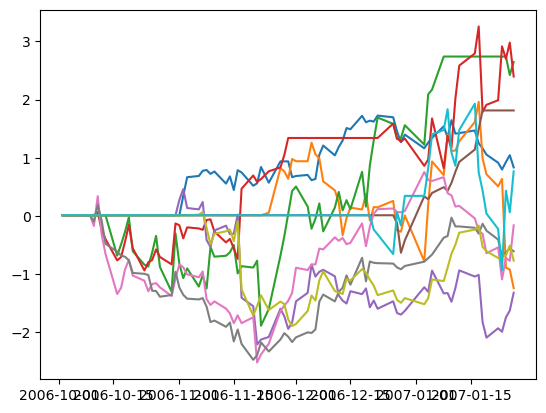

In [227]:
RT2006 = RegularTrading('2006-01-01', '2007-01-01')
LDS2006 = LDS_Trading('2006-01-01', '2007-01-01')
ET2006 = EnhancedTrading('2006-01-01', '2007-01-01')

In [228]:
RT2006_Analytics = Analytics(RT2006)
LDS2006_Analytics = Analytics(LDS2006)
ET2006_Analytics = Analytics(ET2006)

                  Minimum  25% Quantile  50% Quantile  75% Quantile  \
Monetary Return  0.010000      0.010000      0.010000      1.573243   
Sharpe Ratio    -0.145804     -0.135976     -0.107603     -0.073869   
Trading Days     0.000000      0.000000      0.000000      8.500000   

                   Maximum      Mean  
Monetary Return   3.509563  0.751345  
Sharpe Ratio     -0.047957 -0.102242  
Trading Days     36.000000  6.629032  
                  Minimum  25% Quantile  50% Quantile  75% Quantile  \
Monetary Return -2.078884     -0.081884      0.343452      1.713419   
Sharpe Ratio    -0.172521     -0.125800     -0.047927      0.121897   
Trading Days     0.000000     18.000000     25.500000     43.000000   

                   Maximum       Mean  
Monetary Return   3.509556   0.705247  
Sharpe Ratio      0.156924  -0.002314  
Trading Days     61.000000  29.107527  
                  Minimum  25% Quantile  50% Quantile  75% Quantile  \
Monetary Return -1.606550       0.01000    

In [233]:
LDS2006_Analytics.analytics_df.head(n=10).transpose()

,Monetary Return,Sharpe Ratio,Trading Days
Minimum,-2.078884,-0.172521,0.000000
25% Quantile,-0.081884,-0.125800,18.000000
50% Quantile,0.343452,-0.047927,25.500000
75% Quantile,1.713419,0.121897,43.000000
Maximum,3.509556,0.156924,61.000000
Mean,0.705247,-0.002314,29.107527


In [234]:
for i in RT2006.trading_data:
    print(RT2006.trading_data[i][0].sharpe)

nan
nan
nan
nan
nan
-0.1458036153130741
-0.13269971744632902
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-0.08250629599165683
-0.047957442197644584
nan
nan


In [235]:
RT2006_Analytics.sharpe_quantiles

{0: -0.1458036153130741,
 0.25: -0.13597569191301528,
 0.5: -0.10760300671899292,
 0.75: -0.07386908254315377,
 1: -0.047957442197644584,
 'mean': -0.10224176773717612}

In [236]:
ET2006_Analytics.analytics_df.head(n=10).transpose()

,Monetary Return,Sharpe Ratio,Trading Days
Minimum,-1.606550,-0.172544,0.000000
25% Quantile,0.010000,-0.105380,0.000000
50% Quantile,0.779161,-0.038181,2.000000
75% Quantile,1.994618,0.120212,21.000000
Maximum,3.509562,0.156924,57.000000
Mean,0.938366,0.000424,10.419355


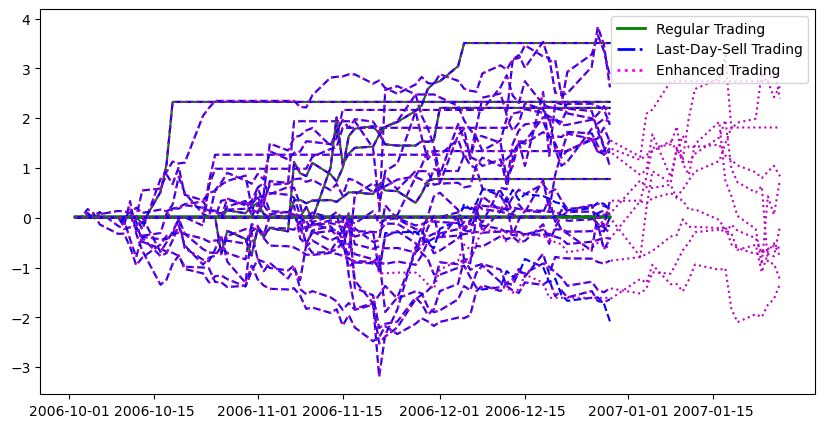

In [289]:

RT_patch = Line2D([], [], color = "green", linestyle="-", linewidth= 2)
LSD_patch = Line2D([], [], color = "blue", linestyle = "-.", linewidth = 2)
ET_patch = Line2D([], [], color = "magenta", linestyle = ":", linewidth = 2)


plt.figure(figsize=(10,5))
plt.legend(handles = [RT_patch, LSD_patch, ET_patch], labels = ["Regular Trading", "Last-Day-Sell Trading", "Enhanced Trading"], loc = "upper right")

for i in RT2006.trading_data:
    plt.plot(RT2006.trading_data[i][0].pf_value, 'g-', label = '_RegularTrading')
    plt.plot(LDS2006.trading_data[i][0].pf_value, 'b--', label = '_LastDayTrading' )
    plt.plot(ET2006.trading_data[i][0].pf_value, 'm:', label = '_EnhancedTrading')




# Finanzkrise 2008

[*********************100%***********************]  25 of 25 completed

3 Failed downloads:
- NCLH: Data doesn't exist for startDate = 1178683200, endDate = 1210219200
- GNRC: Data doesn't exist for startDate = 1178683200, endDate = 1210219200
- CFG: Data doesn't exist for startDate = 1178683200, endDate = 1210219200
0 0.01 0 0
1 0.01 0 0
2 0.01 0 0
3 0.01 0 0
4 0.01 0 0
5 0.01 0 0
6 0.01 0 0
7 0.01 1.1771684377009364 -1.0
8 0.01 1.1771684377009364 -1.0
9 0.01 1.1771684377009364 -1.0
10 0.01 1.1771684377009364 -1.0
11 0.01 1.1771684377009364 -1.0
12 0.01 1.1771684377009364 -1.0
13 0.01 1.1771684377009364 -1.0
14 0.01 1.1771684377009364 -1.0
15 0.01 1.1771684377009364 -1.0
16 0.01 1.1771684377009364 -1.0
17 0.01 1.1771684377009364 -1.0
18 0.01 1.1771684377009364 -1.0
19 0.01 1.1771684377009364 -1.0
20 0.01 1.1771684377009364 -1.0
21 0.01 1.1771684377009364 -1.0
22 0.01 1.1771684377009364 -1.0
23 0.01 1.1771684377009364 -1.0
24 0.01 1.1771684377009364 -1.0
25 0.01 1.1771684377009364 -1.0

/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/

[*********************100%***********************]  25 of 25 completed

3 Failed downloads:
- NCLH: Data doesn't exist for startDate = 1178683200, endDate = 1210219200
- GNRC: Data doesn't exist for startDate = 1178683200, endDate = 1210219200
- CFG: Data doesn't exist for startDate = 1178683200, endDate = 1210219200
0 0.01 0 0
1 0.01 0 0
2 0.01 0 0
3 0.01 0 0
4 0.01 0 0
5 0.01 0 0
6 0.01 0 0
7 0.01 1.1771679615481898 -1.0
8 0.01 1.1771679615481898 -1.0
9 0.01 1.1771679615481898 -1.0
10 0.01 1.1771679615481898 -1.0
11 0.01 1.1771679615481898 -1.0
12 0.01 1.1771679615481898 -1.0
13 0.01 1.1771679615481898 -1.0
14 0.01 1.1771679615481898 -1.0
15 0.01 1.1771679615481898 -1.0
16 0.01 1.1771679615481898 -1.0
17 0.01 1.1771679615481898 -1.0
18 0.01 1.1771679615481898 -1.0
19 0.01 1.1771679615481898 -1.0
20 0.01 1.1771679615481898 -1.0
21 0.01 1.1771679615481898 -1.0
22 0.01 1.1771679615481898 -1.0
23 0.01 1.1771679615481898 -1.0
24 0.01 1.1771679615481898 -1.0
25 0.01 1.1771679615481898 -1.0

/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()


[*********************100%***********************]  25 of 25 completed

3 Failed downloads:
- NCLH: Data doesn't exist for startDate = 1178683200, endDate = 1210219200
- GNRC: Data doesn't exist for startDate = 1178683200, endDate = 1210219200
- CFG: Data doesn't exist for startDate = 1178683200, endDate = 1210219200
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
1.1771681857529357 -1.0 0.01
1.1771681857529357 -1.0 0.01
1.1771681857529357 -1.0 0.01
1.1771681857529357 -1.0 0.01
1.1771681857529357 -1.0 0.01
1.1771681857529357 -1.0 0.01
1.1771681857529357 -1.0 0.01
1.1771681857529357 -1.0 0.01
1.1771681857529357 -1.0 0.01
1.1771681857529357 -1.0 0.01
1.1771681857529357 -1.0 0.01
1.1771681857529357 -1.0 0.01
1.1771681857529357 -1.0 0.01
1.1771681857529357 -1.0 0.01
1.1771681857529357 -1.0 0.01
1.1771681857529357 -1.0 0.01
1.1771681857529357 -1.0 0.01
1.1771681857529357 -1.0 0.01
1.1771681857529357 -1.0 0.01
1.1771681857529357 -1.0 0.01
1.1771681857529357 -1.0 0.01
1.1771681

/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()


[*********************100%***********************]  1 of 1 completed
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.1373945548858522 -1.0 0.01
1.13739

/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()


[*********************100%***********************]  1 of 1 completed
0 0 0.01
0 0 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.729949100324991 0.01
-1.0 0.7299491003

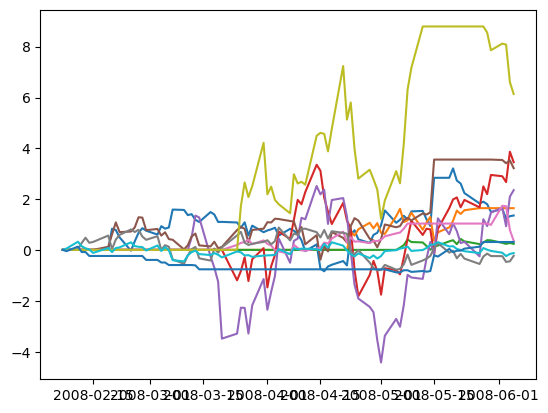

In [290]:
RT2008 = RegularTrading('2007-05-09', '2008-05-08')
LDS2008 = LDS_Trading('2007-05-09', '2008-05-08')
ET2008 = EnhancedTrading('2007-05-09', '2008-05-08')

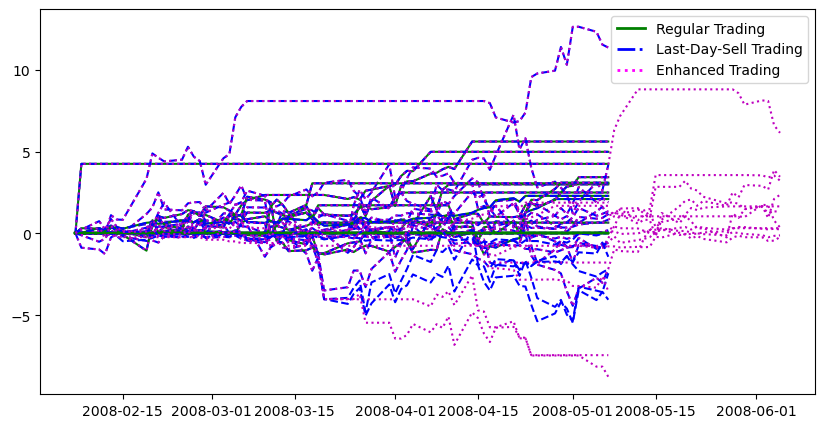

In [316]:
RT_patch = Line2D([], [], color = "green", linestyle="-", linewidth= 2)
LSD_patch = Line2D([], [], color = "blue", linestyle = "-.", linewidth = 2)
ET_patch = Line2D([], [], color = "magenta", linestyle = ":", linewidth = 2)


plt.figure(figsize=(10,5))
plt.legend(handles = [RT_patch, LSD_patch, ET_patch], labels = ["Regular Trading", "Last-Day-Sell Trading", "Enhanced Trading"], loc = "upper right")

for i in RT2008.trading_data:
    plt.plot(RT2008.trading_data[i][0].pf_value, 'g-', label = '_RegularTrading')
    plt.plot(LDS2008.trading_data[i][0].pf_value, 'b--', label = '_LastDayTrading' )
    plt.plot(ET2008.trading_data[i][0].pf_value, 'm:', label = '_EnhancedTrading')



In [292]:
RT2008_Analytics = Analytics(RT2008)
LDS2008_Analytics = Analytics(LDS2008)
ET2008_Analytics = Analytics(ET2008)

                  Minimum  25% Quantile  50% Quantile  75% Quantile  \
Monetary Return  0.010000      0.010000         0.010      2.445472   
Sharpe Ratio    -0.274821      0.062046         0.127      0.133253   
Trading Days     0.000000      0.000000         0.000     14.875000   

                   Maximum      Mean  
Monetary Return   8.081366  1.272799  
Sharpe Ratio      0.209029  0.065599  
Trading Days     56.000000  8.058824  
                  Minimum  25% Quantile  50% Quantile  75% Quantile  \
Monetary Return -4.046104      0.010000      0.750558      2.872125   
Sharpe Ratio    -0.274818      0.035213      0.127000      0.132140   
Trading Days     0.000000     11.875000     33.000000     56.000000   

                   Maximum       Mean  
Monetary Return  11.344075   1.271967  
Sharpe Ratio      0.209029   0.061172  
Trading Days     62.000000  31.588235  
                  Minimum  25% Quantile  50% Quantile  75% Quantile  \
Monetary Return -8.749889      0.010000    

In [293]:
RT2008_Analytics.analytics_df.transpose()

,Monetary Return,Sharpe Ratio,Trading Days
Minimum,0.010000,-0.274821,0.000000
25% Quantile,0.010000,0.062046,0.000000
50% Quantile,0.010000,0.127000,0.000000
75% Quantile,2.445472,0.133253,14.875000
Maximum,8.081366,0.209029,56.000000
Mean,1.272799,0.065599,8.058824


In [294]:
LDS2008_Analytics.analytics_df.transpose()

,Monetary Return,Sharpe Ratio,Trading Days
Minimum,-4.046104,-0.274818,0.000000
25% Quantile,0.010000,0.035213,11.875000
50% Quantile,0.750558,0.127000,33.000000
75% Quantile,2.872125,0.132140,56.000000
Maximum,11.344075,0.209029,62.000000
Mean,1.271967,0.061172,31.588235


In [295]:
ET2008_Analytics.analytics_df.transpose()

,Monetary Return,Sharpe Ratio,Trading Days
Minimum,-8.749889,-0.263291,0.000000
25% Quantile,0.010000,-0.049461,0.250000
50% Quantile,1.667267,0.087407,15.500000
75% Quantile,3.088116,0.131971,31.500000
Maximum,11.344135,0.173150,62.000000
Mean,1.450550,0.036083,20.196078


In [298]:
for i in ET2008.trading_data:
    print(ET2008.trading_data[i][0].sharpe)

0.07086163648319706
0.11456298004839753
-0.2632913264645796
0.15993538341655805
0.17315004833433764
0.13197053135271336
-0.1366212384537253
0.13453630233015731
0.04727990631928364
0.11819493363131067
nan
0.12700012700019048
0.11348733883993493
nan
nan
-0.10171085652056748
0.13213960553545573
0.08740720531868328
0.056422879569208745
0.1406189907240395
nan
nan
-0.049461441598487955
0.11233132946955308
0.1323929360948594
0.03390620185856622
0.07690891202330233
-0.14827896984468192
0.12775326069184476
-0.18716562657312819
0.15680758055383145
-0.17180451859251855
-0.13137058059793866
-0.011552111670913858


# Coronapandemie 2020

[*********************100%***********************]  25 of 25 completed
0 0.01 0.3981032543803393 -1.0
1 0.01 0.3981032543803393 -1.0
0
2
s1y -72.10015869140625
s1i 80.24516563705927
s2y 72.10015869140625
s2i -70.71991729736328
181.10919189453125 201.5687255859375
72.10015869140625 70.71991729736328
position closed
2 9.535248339695992 0 0
3 9.535248339695992 0 0
4 9.535248339695992 0 0
5 9.535248339695992 0 0
6 9.535248339695992 0 0
7 9.535248339695992 0 0
8 9.535248339695992 0 0
9 9.535248339695992 0 0
10 9.535248339695992 0 0
11 9.535248339695992 0 0
12 9.535248339695992 0 0
13 9.535248339695992 0 0
14 9.535248339695992 0 0
15 9.535248339695992 0 0
16 9.535248339695992 0 0
17 9.535248339695992 0 0
18 9.535248339695992 0 0
19 9.535248339695992 0 0
20 9.535248339695992 0 0
21 9.535248339695992 0 0
22 9.535248339695992 0 0
23 9.535248339695992 0 0
24 9.535248339695992 0 0
25 9.535248339695992 0 0
26 9.535248339695992 0 0
27 9.535248339695992 0.3966162702918235 -1.0
28 9.535248339695992 0

/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/

20 0.01 0 0
21 0.01 0 0
22 0.01 0 0
23 0.01 0 0
24 0.01 0 0
25 0.01 0 0
26 0.01 0 0
27 0.01 0 0
28 0.01 0 0
29 0.01 0 0
30 0.01 0 0
31 0.01 0 0
32 0.01 0 0
33 0.01 0 0
34 0.01 0 0
35 0.01 0 0
36 0.01 0 0
37 0.01 0 0
38 0.01 0 0
39 0.01 0 0
40 0.01 0 0
41 0.01 0 0
42 0.01 0 0
43 0.01 0 0
44 0.01 0 0
45 0.01 0 0
46 0.01 0 0
47 0.01 0 0
48 0.01 0 0
49 0.01 0 0
50 0.01 0 0
51 0.01 0 0
52 0.01 0 0
53 0.01 0 0
54 0.01 0 0
55 0.01 0 0
56 0.01 0 0
57 0.01 0 0
58 0.01 0 0
59 0.01 0 0
60 0.01 0 0
61 0.01 0 0
62 0.01 0 0
0 0.01 0.7753710199835339 -1.0
1 0.01 0.7753710199835339 -1.0
2 0.01 0.7753710199835339 -1.0
3 0.01 0.7753710199835339 -1.0
4 0.01 0.7753710199835339 -1.0
5 0.01 0.7753710199835339 -1.0
6 0.01 0.7753710199835339 -1.0
7 0.01 0.7753710199835339 -1.0
8 0.01 0.7753710199835339 -1.0
9 0.01 0.7753710199835339 -1.0
10 0.01 0.7753710199835339 -1.0
11 0.01 0.7753710199835339 -1.0
12 0.01 0.7753710199835339 -1.0
13 0.01 0.7753710199835339 -1.0
14 0.01 0.7753710199835339 -1.0
15 0.01 0.7753

/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/

[*********************100%***********************]  25 of 25 completed
0 0.01 0.3981032543803393 -1.0
1 0.01 0.3981032543803393 -1.0
position closed
2 9.535254414269582 0 0
3 9.535254414269582 0 0
4 9.535254414269582 0 0
5 9.535254414269582 0 0
6 9.535254414269582 0 0
7 9.535254414269582 0 0
8 9.535254414269582 0 0
9 9.535254414269582 0 0
10 9.535254414269582 0 0
11 9.535254414269582 0 0
12 9.535254414269582 0 0
13 9.535254414269582 0 0
14 9.535254414269582 0 0
15 9.535254414269582 0 0
16 9.535254414269582 0 0
17 9.535254414269582 0 0
18 9.535254414269582 0 0
19 9.535254414269582 0 0
20 9.535254414269582 0 0
21 9.535254414269582 0 0
22 9.535254414269582 0 0
23 9.535254414269582 0 0
24 9.535254414269582 0 0
25 9.535254414269582 0 0
26 9.535254414269582 0 0
27 9.535254414269582 0.39661623409585217 -1.0
28 9.535254414269582 0.39661623409585217 -1.0
29 9.535254414269582 0.39661623409585217 -1.0
30 9.535254414269582 0.39661623409585217 -1.0
31 9.535254414269582 0.39661623409585217 -1.0
32 9

/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()
/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()


[*********************100%***********************]  25 of 25 completed
0.3981033300472291 -1.0 0.01
0.3981033300472291 -1.0 0.01
position closed
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0 0 9.535269666349288
0.3966163064877949 -1.0 9.535269666349288
0.3966163064877949 -1.0 9.535269666349288
0.3966163064877949 -1.0 9.535269666349288
0.3966163064877949 -1.0 9.535269666349288
0.3966163064877949 -1.0 9.535269666349288
0.3966163064877949 -1.0 9.535269666349288
0.3966163064877949 -1.0 9.535269666349288
0.396616306

/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0.9724213986193257 -1.0 0.01
0.9724213986193257 -1.0 0.01
0.9724213986193257 -1.0 0.01
0.9724213986193257 -1.0 0.01
0.9724213986193257 -1.0 0.01
0.9724213986193257 -1.0 0.01
0.9724213986193257 -1.0 0.01
0.9724213986193257 -1.0 0.01
0.9724213986193257 -1.0 0.01
0.9724213986193257 -1.0 0.01
0.9724213986193257 -1.0 0.01
0.9724213986193257 -1.0 0.01
0.97242139

/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
0.16031764894804792 -1.0 0.01
0.16031764894804792 -1.0 0.01
0.16031764894804792 -1.0 0.01
0.16031764894804792 -1.0 0.01
0.16031764894804792 -1.0 0.01
0.16031764894804792 -1.0 0.01
0.16031764894804792 -1.0 0.01
0.16031764894804792 -1.0 0.01
0.16031764894804792 -1.0 0.01
0.16031764894804792 -1.0 0.01
0.16031764894804792 -1.0 0.01
0.16031764894804792 -1.0 0.01
0.16031764894804792 -1.0 0.01
0.16031764894804792 -1.0 0.01
position closed
0 0 3.038552001095768
0 0 3.038552001095768
0 0 3.038552001095768
0 0 3.038552001095768
0 0 3.038552001095768
0 0 3.038552001095768
0 0 3.038552001095768
0 0 3.038552001095768
0 0 3.038552001095768
0 0 3.038552001095768
0 0 3.038552001095768
0 0 3.038552001095768
0 0 3.038552001095768
0 0 3.038552001095768
0 0 3.038552001095768
0 0 3.038552001095768
0 0 3.038552001095768
0 0 3.038552001095768
0 0 3.038552001095768
0 0 3.03

/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()


[*********************100%***********************]  1 of 1 completed
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01
-1.0 1.2008235208860072 0.01


/var/folders/mv/yf3t7r4j70dbb8v1jst0rzh00000gn/T/ipykernel_19219/715343860.py:22: RuntimeWarning: invalid value encountered in double_scalars
  self.sharpe = returns.mean()/returns.std()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
0 0 0.01
-1.0 0.686442333597807 0.01
-1.0 0.686442333597807 0.01
-1.0 0.686442333597807 0.01
-1.0 0.686442333597807 0.01
-1.0 0.686442333597807 0.01
-1.0 0.686442333597807 0.01
-1.0 0.686442333597807 0.01
-1.0 0.686442333597807 0.01
-1.0 0.686442333597807 0.01
-1.0 0.686442333597807 0.01
-1.0 0.686442333597807 0.01
-1.0 0.686442333597807 0.01
-1.0 0.686442333597807 0.01
-1.0 0.686442333597807 0.01
-1.0 0.686442333597807 0.01
-1.0 0.686442333597807 0.01
-1.0 0.686442333597807 0.01
-1.0 0.686442333597807 0.01
-1.0 0.686442333597807 0.01
-1.0 0.686442333597807 0.01
-1.0 0.686442333597807 0.01
-1.0 0.686442333597807 0.01
-1.0 0.686442333597807 0.01
-1.0 0.6864423335978

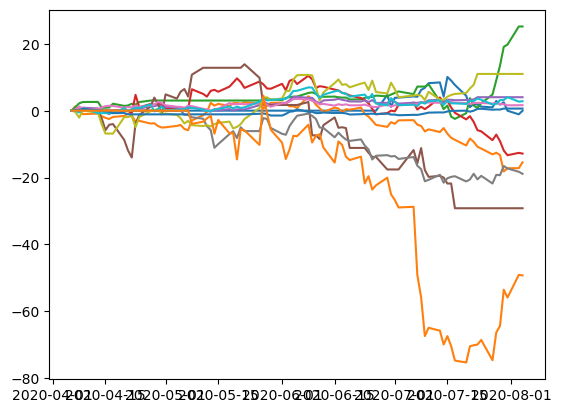

In [299]:
RT2020 = RegularTrading('2019-07-08', '2020-07-07')
LDS2020 = LDS_Trading('2019-07-08', '2020-07-07')
ET2020 = EnhancedTrading('2019-07-08', '2020-07-07')

In [300]:
RT2020_Analytics = Analytics(RT2020)
LDS2020_Analytics = Analytics(LDS2020)
ET2020_Analytics = Analytics(ET2020)

                  Minimum  25% Quantile  50% Quantile  75% Quantile  \
Monetary Return  0.010000      0.010000      0.010000     10.673095   
Sharpe Ratio    -0.185167     -0.126843      0.123081      0.127645   
Trading Days     0.000000      0.000000      0.000000     14.000000   

                    Maximum      Mean  
Monetary Return  118.992838  8.419129  
Sharpe Ratio       0.130970  0.019294  
Trading Days      42.000000  7.122222  
                   Minimum  25% Quantile  50% Quantile  75% Quantile  \
Monetary Return -37.968433     -0.719512      2.374117     12.780086   
Sharpe Ratio     -0.185166     -0.124399      0.102947      0.127762   
Trading Days      0.000000     12.000000     25.500000     56.000000   

                    Maximum       Mean  
Monetary Return  107.372476   6.093962  
Sharpe Ratio       0.201797   0.024921  
Trading Days      62.000000  31.414815  
                   Minimum  25% Quantile  50% Quantile  75% Quantile  \
Monetary Return -37.968418    

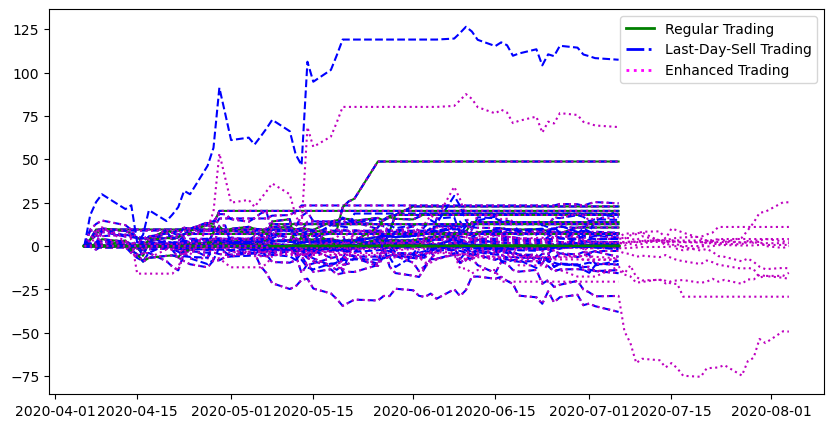

In [317]:
RT_patch = Line2D([], [], color = "green", linestyle="-", linewidth= 2)
LSD_patch = Line2D([], [], color = "blue", linestyle = "-.", linewidth = 2)
ET_patch = Line2D([], [], color = "magenta", linestyle = ":", linewidth = 2)


plt.figure(figsize=(10,5))
plt.legend(handles = [RT_patch, LSD_patch, ET_patch], labels = ["Regular Trading", "Last-Day-Sell Trading", "Enhanced Trading"], loc = "upper right")

for i in RT2020.trading_data:
    plt.plot(RT2020.trading_data[i][0].pf_value, 'g-', label = '_RegularTrading')
    plt.plot(LDS2020.trading_data[i][0].pf_value, 'b--', label = '_LastDayTrading' )
    plt.plot(ET2020.trading_data[i][0].pf_value, 'm:', label = '_EnhancedTrading')

In [303]:
RT2020_Analytics.analytics_df.transpose()

,Monetary Return,Sharpe Ratio,Trading Days
Minimum,0.010000,-0.185167,0.000000
25% Quantile,0.010000,-0.126843,0.000000
50% Quantile,0.010000,0.123081,0.000000
75% Quantile,10.673095,0.127645,14.000000
Maximum,118.992838,0.130970,42.000000
Mean,8.419129,0.019294,7.122222


In [307]:
for i, t in enumerate(RT2020.trading_data):
    print(i, RT2020.trading_data[t][0].money)

0 18.579226044005885
1 4.148176360490661
2 0.01
3 18.710243370983573
4 0.01
5 0.01
6 7.476334609322295
7 0.01
8 0.01
9 8.89155082814201
10 22.809485647430233
11 0.01
12 0.01
13 3.038554447348959
14 0.01
15 0.01
16 10.673095021419387
17 0.01
18 0.01
19 23.37594749484827
20 0.01
21 17.924578992848563
22 0.01
23 8.8430429338898
24 48.7049688441332
25 0.01
26 12.841247554021473
27 0.01
28 0.01
29 0.01
30 0.01
31 0.01
32 0.01
33 20.25163865658956
34 0.01
35 13.771360996659377
36 6.95549888884136
37 0.01
38 0.01
39 0.01
40 0.01
41 12.60301073553513
42 118.9928377317557
43 0.01
44 0.01


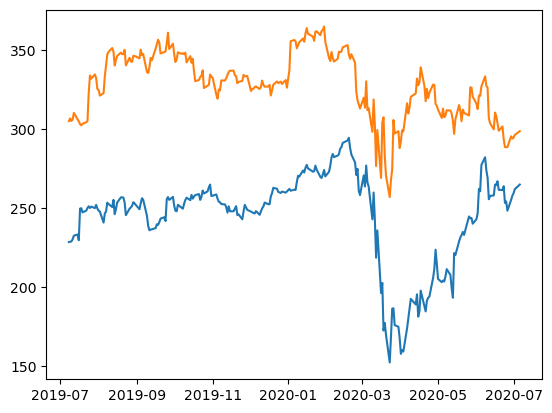

In [321]:
plt.plot(RT2020.data[LDS2020.trading_data[42][0].s1_name])
plt.plot(RT2020.data[LDS2020.trading_data[42][0].s2_name])
#LDS2020.trading_data[42][0].s2_name

In [304]:
LDS2020_Analytics.analytics_df.transpose()

,Monetary Return,Sharpe Ratio,Trading Days
Minimum,-37.968433,-0.185166,0.000000
25% Quantile,-0.719512,-0.124399,12.000000
50% Quantile,2.374117,0.102947,25.500000
75% Quantile,12.780086,0.127762,56.000000
Maximum,107.372476,0.201797,62.000000
Mean,6.093962,0.024921,31.414815


In [305]:
ET2020_Analytics.analytics_df.transpose()

,Monetary Return,Sharpe Ratio,Trading Days
Minimum,-37.968418,-0.185165,0.000000
25% Quantile,-0.732080,-0.125329,0.000000
50% Quantile,0.292968,0.087871,5.666667
75% Quantile,12.603005,0.127762,14.333333
Maximum,68.562305,0.201802,83.000000
Mean,4.728427,0.013101,12.036508
